# Data Mining II Practical Assignment

## Iván Marcelo Carrera Izurieta
### Programa de Doutoramento em Ciência de Computadores FCUP.

#### Predicting Cellular line - Drug Interactions as Recommender System
This work presents an analysis for the relationships among cellular lines and pharmaceutical drugs.

##### Web mining
There are two main source databases for cellular lines: [Cellosaurus](https://web.expasy.org/cellosaurus/)
and [ChEMBL](https://www.ebi.ac.uk/chembl/).
First of all, we have to identify the cellular lines. File contains a list of cellular lines, with their synonyms

In [23]:
import json
filename = 'data/cell_list.json'
cell_list = json.load(open(filename,'r'))
# print first 10 elements
for cell in cell_list[:10]:
    print(cell)

{'CVCL_1567': ['NCI-H522', 'H522', 'NCIH522', 'H-522', 'NCI.H522', 'NCI522', 'CHEMBL3308392', 'NCI-522']}
{'CVCL_1180': ['DOK', 'Dysplastic Oral Keratinocyte', 'CHEMBL3308727']}
{'CVCL_0382': ['L1210', 'Leukemic 1210', 'L 1210', 'Leukemia L1210', 'Leukemia 1210', 'CHEMBL3308391', 'L-1210']}
{'CVCL_0554': ['T24', 'T-24', 'CHEMBL3307700', 'T 24']}
{'CVCL_1786': ['VMCub1', 'VM-CUB-I', 'VM-CUB-1', 'VM Cub 1', 'CHEMBL3308476', 'VMCUB1', 'VM-CUB1', 'VMCUB-1']}
{'CVCL_1256': ['HCC1599', 'CHEMBL3308262', 'HCC-1599']}
{'CVCL_1399': ['MC 116', 'MC-116', 'MC116', 'CHEMBL3308210']}
{'CVCL_1084': ['BFTC909', 'BFTC 909', 'BFTC-909', 'CHEMBL3308710']}
{'CVCL_1527': ['NCIH2107', 'H2107', 'NCI-H2107', 'H-2107']}
{'CVCL_0076': ['CHEMBL3307273', 'SNU16', 'SNU-16', 'NCI-SNU-16']}


In order to form a corpus, we first have to retrieve all the paper abstracts from [PubMed](https://www.ncbi.nlm.nih.gov/pubmed/).
PubMed has an API for retrieving papers included in the `Biopython` library. API access needs a key.

Also, once the abstracts are retrieved, we can store them in memory as a dictionary.

In [24]:
# a few methods for parsing information
# replace special chars
def replace_spchars(original_string):
    # new_string = original_string.encode('ascii', errors='ignore')
    for c in ['\n', '>', '<', '&', '(', ')', '[', ']', '%', '=', ',', '.', '+', '\\', '/']:
        new_string = original_string.replace(c, ' ')
    return new_string

# transform an abstract from text to a dictionary
def to_dict(abstract_string, cell_name):
    abstract_ = dict()
    doc_list = abstract_string.split('\n\n')
    title = doc_list[1]
    try:
        title = title.replace('\n', ' ')
    except:
        pass
    title = replace_spchars(title)
    len_list = []
    for item in doc_list:
        len_list.append(len(item))
        if 'PMID:' in item:
            item = item.split('PMID:')[1]
            try:
                item = item.replace(' [Indexed for MEDLINE]', '')
            except:
                pass
            item = item.replace(' ', '')
            index = 'PMID:' + item
    # abstract should be the biggest item of doc_list
    abstract = doc_list[len_list.index(max(len_list))]
    abstract = replace_spchars(abstract).replace('\n', ' ')
    if abstract.startswith('Author information:'):
        abstract = ''
    abstract = (title + ' ' + abstract)
    abstract_['title'] = title
    abstract_['index'] = index
    abstract_['document'] = abstract
    abstract_['cell_id'] = cell_name
    return abstract_

`Biopython` includes the `Entrez` library for accessing PubMed

In [31]:
from Bio import Entrez
import time
import os
# list_toquery transforms the list of synonyms into a query
def list_toquery(list_):
    string = ''
    if list_ is None:
        print('List is NONE')
    if type(list_) is str:
        list_ = [list_]
    for element in list_:
        if element is None:
            x = ''
        else:
            x = str(element)
        if x != '':
            string = string + '("' + x + '"[Title/Abstract]) OR '
    return string[:-4] + ' AND ((cell line[Title/Abstract]) OR (cellular line[Title/Abstract]) OR ' \
                         '(cell-line[Title/Abstract]))'

# query returns a list of PubMed IDs
def search_idlist(query):
    Entrez.email = 'ivan.carrera@epn.edu.ec'
    Entrez.api_key = 'e0cd8267acda02738ba691d40bda130c4808'
    try:
        handle = Entrez.esearch(db='pubmed', sort='relevance', retmax='5000', retmode='xml', term=query)
        results = Entrez.read(handle)
    except Exception as e:
        print('Something is happening with queries about: ', query, e)
        time.sleep(2) # this sleep is performed when PubMed servers reject queries
        return search_idlist(query)
    return results['IdList']

# once you have a PubMed ID, you can retrieve the abstract
def get_abstract(pmid):
    Entrez.api_key = 'e0cd8267acda02738ba691d40bda130c4808'
    try:
        handle = Entrez.efetch(db='pubmed', id=pmid, retmode='text', rettype='abstract')
        return handle.read()
    except Exception as e:
        print(pmid, e)

# abstracts have to be processed and stored
def process_abstracts(cell_):
    file_prefix = 'data/cell_json/cell_abstracts_'
    cell_id = list(cell_.keys())[0]
    if os.path.exists(file_prefix + replace_spchars(cell_id) + '.json'):
        print(cell_id, 'already exists')
        pass
    else:
        #global gene_list
        cell_abstracts = dict()
        keyword_list = list(cell_.values())[0]
        query = list_toquery(keyword_list)
        idlist = search_idlist(query)
        # print(cell_id, len(idlist), 'abstracts')
        cell_abstracts['cell_id'] = cell_id
        cell_abstracts['documents'] = list()
        try:
            for id_item in idlist:
                abstract_text = get_abstract(id_item)
                abstract_dict = to_dict(abstract_text, cell_name=cell_id)
                cell_abstracts['documents'].append(abstract_dict)
        except Exception as e:
            print('Parsing error', e)
            pass

        json.dump(cell_abstracts, fp=open(file_prefix + replace_spchars(cell_id) + '.json', 'w'))
        # print('got', len(cell_abstracts['documents']), 'abstracts to JSON file')

Methods are defined. It is time for us to retrieve all abstracts.
In parallel, because this can be very time consuming.

In [32]:
# this should be done in parallel
# Binder does not support multiprocessing package
from time import time
t0 = time()
# Only retrieving 10 first cell lines
for cell_ in cell_list[:10]:
    process_abstracts(cell_)
retrieve_time = time() - t0
print("Abstract retrieving time: %0.3fs" % retrieve_time)

CVCL_1567 already exists
CVCL_1180 already exists
CVCL_0382 already exists
CVCL_0554 already exists
CVCL_1786 already exists
CVCL_1256 already exists
CVCL_1399 already exists
CVCL_1084 already exists
CVCL_1527 already exists
CVCL_0076 already exists
Abstract retrieving time: 0.011s


##### Text mining
##### Text pre-processing
We have a list of files. One file per cellular line. Each file contains a document for each abstract.

In [33]:
import os
#filedir = '/home/ivan/ccap/data/cell_json/'
filedir = 'C:\\Users\\ivanc\\PycharmProjects\\ccap\\data\\cell_json\\'
filelist = os.listdir(filedir)
print(len(filelist)/2, 'files')
print('An example:')
with open(filedir + filelist[0],'r') as f:
    print(f.readline()[:1000])

684.5 files
An example:
{"cell_id": "A2780 cisR", "documents": [{"title": "Changes in the in vitro activity of platinum drugs when administered in two aliquots.", "index": "PMID:27566066", "document": "Changes in the in vitro activity of platinum drugs when administered in two aliquots. BACKGROUND: The management of ovarian cancer remains a challenge. Because of the  lack of early symptoms, it is often diagnosed at a late stage when it is likely to have metastasized beyond ovaries. Currently, platinum based chemotherapy is the primary treatment for the disease. However acquired drug resistance remains an on-going problem. As cisplatin brings about apoptosis by intrinsic and extrinsic pathways, this study aimed to determine changes in activity of platinum drugs when administered in two aliquots as against a bolus and sought to determine association with changes in GSH, speciation of platinum drugs and changes in protein expression. METHODS: The efficacy of administering cisplatin, carbo

Once we have the files, we can create a corpus.
We retrieve all abstracts from the JSON files to form the corpus.
For relevance, we inly select cellular lines with more than 10 abstracts.

In [34]:
import json
import logging
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

corpus = list()
cell_class_list = list()
for file in filelist:
    if file.startswith('cell_abstracts_'):
        cell = json.load(fp=open(filedir + file,'r'))
        cell_id = cell['cell_id']
        n_documents = len(cell['documents'])
        # print(file, n_documents)
        # Use only if cell line has at least 10 abstracts
        if int(n_documents) > 10:
            for document in cell['documents']:
                abstract = document['document']
                index = document['index']
                corpus.append(abstract)
                cell_class_list.append(cell_id)
cell_set = set(cell_class_list)
print(len(corpus), 'documents in corpus, from', len(cell_set), 'cell lines')

5752 documents in corpus, from 240 cell lines


Corpus is now populated.
Now, we want to process the abstracts with TF-IDF.
We transform the corpus into a Document-Term Matrix.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stem = PorterStemmer()
stemmed_corpus = list()
for doc in corpus:
    doc = doc.replace('.','').replace(',','').replace(';','').replace(':','')
    stemmed_corpus.append(' '.join([stem.stem(x) for x in doc.split()]))

target_names = list(cell_set)
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=1.0, min_df=2, strip_accents='ascii', stop_words='english',
                             token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
dtm = vectorizer.fit_transform(stemmed_corpus)
print('DTM shape:', dtm.shape)

wordfreq = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('Top 20 words')
print(sorted(wordfreq.items(), key=lambda x: x[1])[:20])

DTM shape: (5752, 14314)
Top 20 words
[('cell', 1.012946296985861), ('line', 1.0271334475144003), ('wa', 1.2550212229174793), ('studi', 1.5130878713156721), ('result', 1.5268287687027096), ('human', 1.5515655388767853), ('use', 1.5822051905658356), ('express', 1.5856335872541352), ('thi', 1.623818308977143), ('activ', 1.6431409995638697), ('effect', 1.6577981573638434), ('cancer', 1.716536974535502), ('induc', 1.931705295275342), ('inhibit', 1.9468234133620919), ('increas', 1.9644509884454053), ('protein', 1.9708554019186737), ('tumor', 2.0338347903517215), ('treatment', 2.1200467002767844), ('investig', 2.1269967416177566), ('level', 2.1475936757083796)]


##### Document Classification
We want to see if cellular lines have specific discriminant vocabulary.
We divide `dtm` in trains and test sets.

In [36]:
# Divide in train and test sets
X_train, X_test, y_train, y_test = train_test_split(dtm, cell_class_list, test_size=0.3, random_state=42,
                                                    shuffle=True)
# feature_names is the vocabulary of terms
feature_names = vectorizer.get_feature_names()

We define a `benchmark` method to apply to several classification methods.

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time

def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    # clf_descr = str(clf).split('(')[0]
    return clf, name, score, train_time, test_time

We define 6 classification methods, some with variants:
* Ridge Classifier
* Passive-Aggressive
* K Nearest Neighbors
* Random Forest
* Support Vector Machine
* Stochastic Gradient Descent Classifier

In [38]:
results = []
for clf, name in [
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (PassiveAggressiveClassifier(max_iter=50, n_jobs=-1), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),
        (RandomForestClassifier(n_jobs=-1), "Random forest"),
        (LinearSVC(penalty="l1", dual=False, tol=1e-3), "LinearSVC L1"),
        (LinearSVC(penalty="l2", dual=False, tol=1e-3), "LinearSVC L2"),
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="l1", n_jobs=-1), "SGDC L1"),
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="l2", n_jobs=-1), "SGDC L2"),
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet", n_jobs=-1),"SGDC Elastic"),
        (Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
        ('classification', LinearSVC(penalty="l2"))]), "LinearSVC with L1-based feature selection")
]:
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, name))
print('=' * 80)
print('Sorted methods by score:')
print(sorted(results, key=lambda x: x[2], reverse=True))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 27.300s
test time:  0.116s
accuracy:   0.688
confusion matrix:
[[ 7  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  8]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=-1, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
train time: 2.142s
test time:  0.163s
accuracy:   0.661
confusion matrix:
[[ 7  0  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  7]]

kNN
_______________

We plot our results.

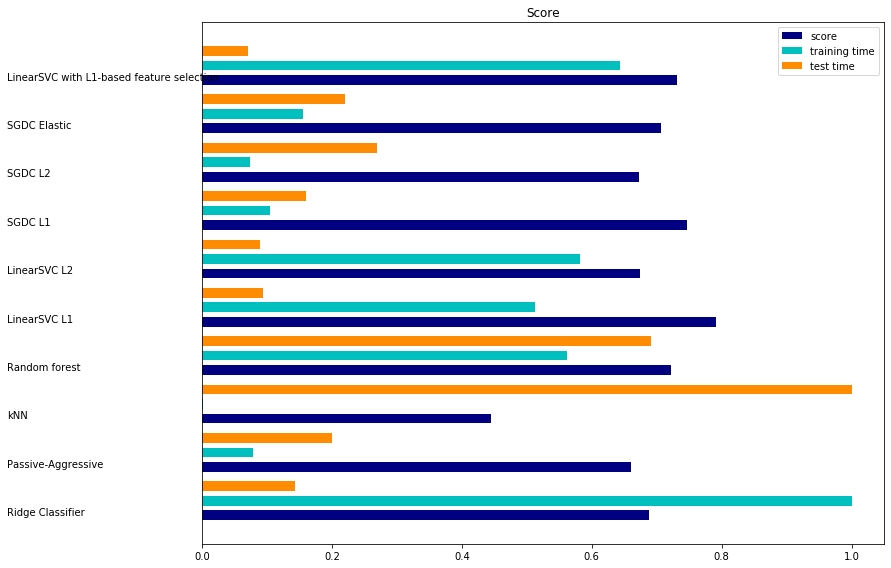

In [39]:
import numpy as np
import matplotlib.pyplot as plt

indices = np.arange(len(results))

results_ = [[x[i] for x in results] for i in range(5)]

clf, clf_names, score, training_time, test_time = results_
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.tight_layout()
plt.savefig('benchmarking_results.png')
plt.show()

According to results, best classifier is:

In [40]:
bc = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
print(bc)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


Feature Selection can show how many features are representative:

In [46]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

dtm_df = pd.DataFrame(dtm.todense())
print('DTM shape:', dtm_df.shape)

results = []
for k in [5000, 8000, 10000, 12000]:
    print('=' * 80)
    dtm_fs = SelectKBest(chi2, k=k).fit_transform(dtm_df, cell_class_list)
    print('k:', k, 'DTM shape:', dtm_fs.shape)
    # Divide in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(dtm_fs, cell_class_list, test_size=0.3, random_state=42,
                                                    shuffle=True)
    clf = LinearSVC(penalty="l1", dual=False, tol=1e-3)
    results.append(benchmark(clf, 'LinearSVC'))


DTM shape: (5752, 14314)
k: 5000 DTM shape: (5752, 5000)
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)
train time: 3.141s
test time:  0.243s
accuracy:   0.795
confusion matrix:
[[ 7  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  7]]

k: 8000 DTM shape: (5752, 8000)
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)
train time: 6.333s
test time:  0.373